In [34]:
import pandas as pd
import pandas as pd
from sklearn import feature_extraction, model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from nltk.corpus import stopwords
# Stemming with NLTK
from nltk.stem.snowball import SnowballStemmer
sw = stopwords.words("english")
stemmer=SnowballStemmer("english")

In [35]:
df=pd.read_excel('troubleshoot_data_set.xlsx')
df.head(3)

,General.Eriref,Observation.Observation,Main Module,Source Files
0,HX89227,BRANCH:\n======\nmaster\n\nEFFECT:\n======\nPM...,NaN,NaN
1,HX89043,1 EFFECT\n1.1 Trouble summary\nBCH is interrup...,cms,lhsj_main/bscs/tests/robotScripts/src/main/tes...
2,HX88922,SLOGAN :\nRounding of clawback with discount i...,bch,lhsj_main/bscs/tests/robotScripts/src/main/tes...


In [36]:
df.describe()

,General.Eriref,Observation.Observation,Main Module,Source Files
count,9577,9577,9439,9438
unique,6200,6160,103,2588
top,HV98266,EFFECT:\n======\n\nPerformance drop after 3 ho...,kw,;
freq,51,51,4711,4523


In [37]:
df.isnull().sum()

General.Eriref               0
Observation.Observation      0
Main Module                138
Source Files               139
dtype: int64

In [38]:
df.dropna(inplace=True)

In [39]:
df.isnull().sum()

General.Eriref             0
Observation.Observation    0
Main Module                0
Source Files               0
dtype: int64

In [40]:
space_remover_dict = dict(zip(df.columns,[name.replace(' ','').lower() for name in df.columns]))
df = df.rename(space_remover_dict,axis=1)
df.head()

,general.eriref,observation.observation,mainmodule,sourcefiles
1,HX89043,1 EFFECT\n1.1 Trouble summary\nBCH is interrup...,cms,lhsj_main/bscs/tests/robotScripts/src/main/tes...
2,HX88922,SLOGAN :\nRounding of clawback with discount i...,bch,lhsj_main/bscs/tests/robotScripts/src/main/tes...
3,HX88991,SLOGAN:- CX - CWS resource assignment issue\n\...,cms,lhsj_main/bscs/cms/src/cms/java/com/lhs/Resour...
4,HX89000,"SLOGAN:- Default value for GPRS activation ""Qu...",cx,lhsj_main/bscs/cms/src/clt/cx/java/com/lhs/ccb...
5,HX89004,SLOGAN:- CX || Memo creation page missing fiel...,cx,lhsj_main/bscs/tests/robotScripts/src/main/tes...


In [41]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [42]:
encoding_pipeline = Pipeline([
    ('encoding',MultiColumnLabelEncoder(columns=['mainmodule','sourcefiles']))
    # add more pipeline steps as needed
])
df_encode=encoding_pipeline.fit_transform(df)[['mainmodule','sourcefiles']]
df_encode.rename(columns={'mainmodule' : 'en_mainmodule','sourcefiles':'en_sourcefiles'},inplace=True)
new_df=pd.concat([df,df_encode], axis=1)
new_df

,general.eriref,observation.observation,mainmodule,sourcefiles,en_mainmodule,en_sourcefiles
1,HX89043,1 EFFECT\n1.1 Trouble summary\nBCH is interrup...,cms,lhsj_main/bscs/tests/robotScripts/src/main/tes...,29,2206
2,HX88922,SLOGAN :\nRounding of clawback with discount i...,bch,lhsj_main/bscs/tests/robotScripts/src/main/tes...,17,2040
3,HX88991,SLOGAN:- CX - CWS resource assignment issue\n\...,cms,lhsj_main/bscs/cms/src/cms/java/com/lhs/Resour...,29,1534
4,HX89000,"SLOGAN:- Default value for GPRS activation ""Qu...",cx,lhsj_main/bscs/cms/src/clt/cx/java/com/lhs/ccb...,33,1227
5,HX89004,SLOGAN:- CX || Memo creation page missing fiel...,cx,lhsj_main/bscs/tests/robotScripts/src/main/tes...,33,2376
...,...,...,...,...,...,...
9556,HQ27483,EFFECT:\nBIR file rejected. Uncertainty about ...,kw,;,58,61
9558,HQ20521,"EFFECT:\r\nModify DA with expiration date, BSC...",kw,;,58,61
9560,HQ15198,EFFECT: Event history will not be correct if t...,kw,;,58,61
9561,HP90064,EFFECT:\nPAM class not changed (and inconsiste...,kw,;,58,61


In [43]:
df_rate=df.groupby('mainmodule').sourcefiles.count().to_frame()
df_rate.reset_index(level=0, inplace=True)

df_mm=df['mainmodule'].value_counts().to_frame()
df_mm.reset_index(level=0, inplace=True)
df_mm['main_pre']=df_mm['mainmodule']/df_mm['mainmodule'].sum()
df_mm

,index,mainmodule,main_pre
0,kw,4711,0.499152
1,cms,867,0.091863
2,cx,548,0.058063
3,dab,384,0.040687
4,bch,326,0.034541
...,...,...,...
98,pbs,1,0.000106
99,rch,1,0.000106
100,udmaplib,1,0.000106
101,bumt,1,0.000106


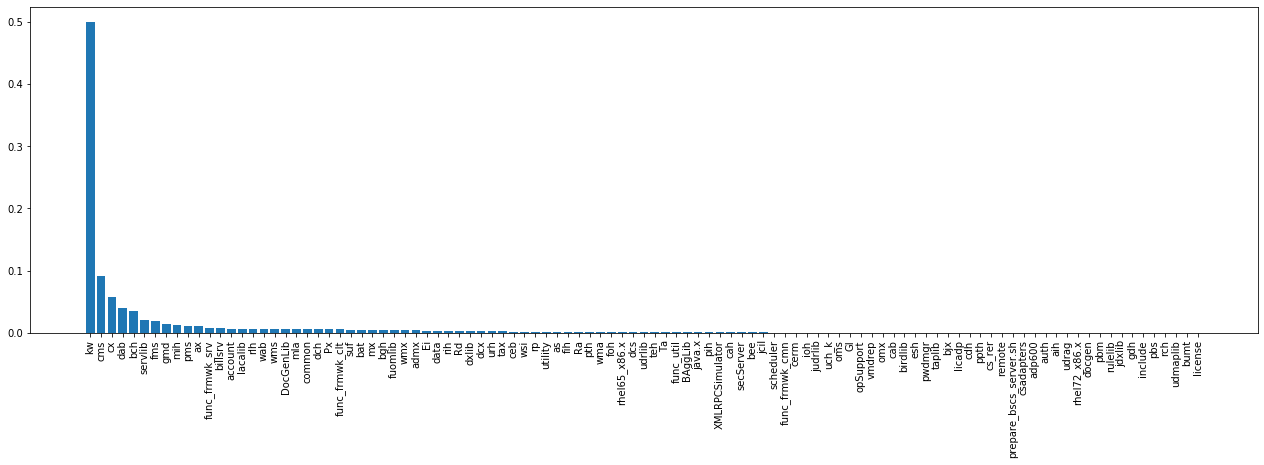

In [44]:
plt.figure(figsize=(22, 6))
locations=np.arange(df.mainmodule.nunique())

plt.bar(locations, df_mm['main_pre'], tick_label=df_mm['index']);
plt.xticks(rotation = 90);

In [45]:
df_rate['sourcefiles'].max()

4711

In [46]:

df_rate.query('sourcefiles == "4711"')

,mainmodule,sourcefiles
58,kw,4711


In [47]:
new_df.query('mainmodule =="kw"')

,general.eriref,observation.observation,mainmodule,sourcefiles,en_mainmodule,en_sourcefiles
13,HX88756,Revert fix of PCP1804 -EP28 (tmo-1.32.19-28) c...,kw,;,58,61
19,HX88459,1 EFFECT\nCommand PRODUCT_OFFERING.WRITE is re...,kw,lhsj_main/bscs/tests/robotScripts/src/main/tes...,58,2266
27,HX87530,SLOGAN:- CX Unable to assign resource after se...,kw,;,58,61
30,HX87132,1 EFFECT\nCurrently two automated tests fail i...,kw,lhsj_main/bscs/tests/robotScripts/src/main/tes...,58,2244
68,HX85094,Issue:-\n=====\n Invoice got generated even th...,kw,;,58,61
...,...,...,...,...,...,...
9552,HQ34493,EFFECT:\r\nAF recovery job for subscriber havi...,kw,;,58,61
9556,HQ27483,EFFECT:\nBIR file rejected. Uncertainty about ...,kw,;,58,61
9558,HQ20521,"EFFECT:\r\nModify DA with expiration date, BSC...",kw,;,58,61
9560,HQ15198,EFFECT: Event history will not be correct if t...,kw,;,58,61


In [48]:
new_df.query('sourcefiles ==";"').index

Int64Index([  13,   27,   68,  101,  102,  103,  107,  158,  182,  213,
            ...
            9516, 9520, 9521, 9523, 9549, 9552, 9556, 9558, 9560, 9561],
           dtype='int64', length=4523)

In [49]:
Source_file_df = new_df[new_df.sourcefiles != ";"]

In [50]:
Source_file_df

,general.eriref,observation.observation,mainmodule,sourcefiles,en_mainmodule,en_sourcefiles
1,HX89043,1 EFFECT\n1.1 Trouble summary\nBCH is interrup...,cms,lhsj_main/bscs/tests/robotScripts/src/main/tes...,29,2206
2,HX88922,SLOGAN :\nRounding of clawback with discount i...,bch,lhsj_main/bscs/tests/robotScripts/src/main/tes...,17,2040
3,HX88991,SLOGAN:- CX - CWS resource assignment issue\n\...,cms,lhsj_main/bscs/cms/src/cms/java/com/lhs/Resour...,29,1534
4,HX89000,"SLOGAN:- Default value for GPRS activation ""Qu...",cx,lhsj_main/bscs/cms/src/clt/cx/java/com/lhs/ccb...,33,1227
5,HX89004,SLOGAN:- CX || Memo creation page missing fiel...,cx,lhsj_main/bscs/tests/robotScripts/src/main/tes...,33,2376
...,...,...,...,...,...,...
9504,HQ86199,Abstract : CSadptor could not establish connec...,csadapters,lhsj_main/bscs/cms/src/csadapters/src/com/lhs/...,32,1648
9526,HQ54935,Error: Data too large for Excel cell,dab,05b8de65cf2 ClearCase update;lhsj_main/bscs/ba...,34,0
9547,HQ41287,EFFECT:\r\nNot all ADMX batch jobs working on ...,bch,298d00809d1 ClearCase update;lhsj_main/bscs/ba...,17,16
9551,HQ35705,EFFECT:\n\nAccount identifers above 255 not po...,cms,129f5776a33 ClearCase update;lhsj_main/bscs/ba...,29,6


In [51]:
df_rate=Source_file_df.groupby('mainmodule').sourcefiles.count().to_frame()
df_rate.reset_index(level=0, inplace=True)

df_mm=Source_file_df['mainmodule'].value_counts().to_frame()
df_mm.reset_index(level=0, inplace=True)
df_mm['main_pre']=df_mm['mainmodule']/df_mm['mainmodule'].sum()
df_mm

,index,mainmodule,main_pre
0,cms,867,0.176399
1,cx,548,0.111495
2,dab,384,0.078128
3,bch,326,0.066328
4,servlib,194,0.039471
...,...,...,...
98,jdxlib,1,0.000203
99,rch,1,0.000203
100,udmaplib,1,0.000203
101,license,1,0.000203


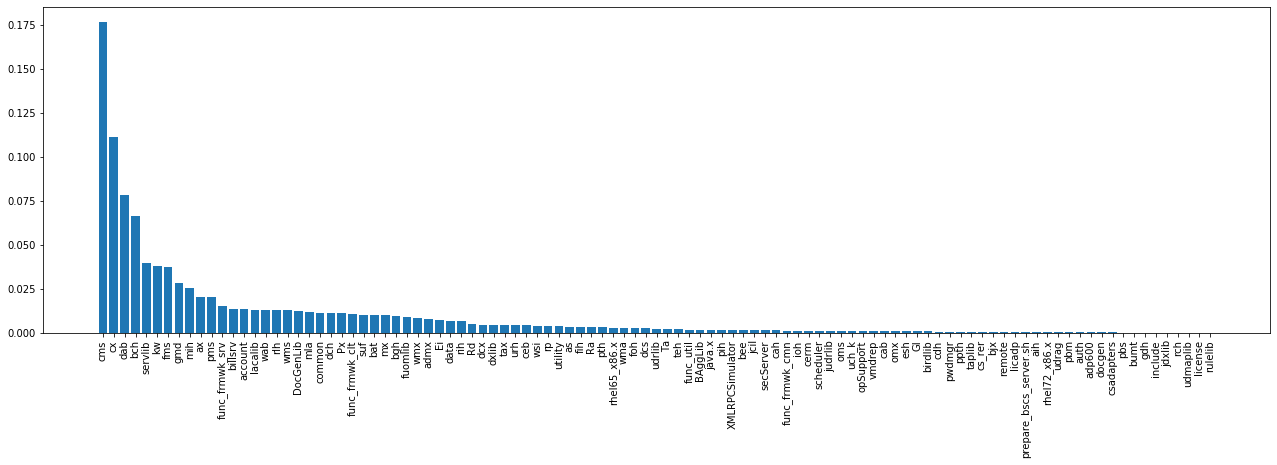

In [52]:
plt.figure(figsize=(22, 6))
locations=np.arange(df.mainmodule.nunique())

plt.bar(locations, df_mm['main_pre'], tick_label=df_mm['index']);
plt.xticks(rotation = 90);

In [22]:
X_main =  feature_extraction.text.CountVectorizer(stop_words = 'english')
X_main = X_main.fit_transform(new_df["observation.observation"])
X_main.shape

(9438, 53364)

In [23]:
y_main=new_df['en_mainmodule']

#y1=df['mainmodule']
#y2=df['sourcefiles']
#le=LabelEncoder()
#le.fit(y)

In [24]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_main, y_main, test_size=0.2, random_state=42)
print([X_train.shape, X_test.shape])
print([y_train.shape, y_test.shape])

[(7550, 53364), (1888, 53364)]
[(7550,), (1888,)]


In [89]:
from sklearn.metrics import precision_score, classification_report, roc_auc_score,average_precision_score,accuracy_score

#model = MultinomialNB()

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('MultinomialNB accuracy:',accuracy_score(y_test, y_pred))
from sklearn.svm import SVC
sv_clf = SVC(kernel="rbf",C=10000,gamma='auto')
sv_clf.fit(X_train, y_train)
sv_pred=sv_clf.predict(X_test)
print('SVM accuracy:',accuracy_score(y_test, sv_pred))

MultinomialNB accuracy: 0.6302966101694916
SVM accuracy: 0.7733050847457628


0.7733050847457628


In [72]:
# prepare the data for NLTK 
new_df['unstemmed']=new_df['observation.observation'].apply(lambda x:x.split())
new_df.head()

,general.eriref,observation.observation,mainmodule,sourcefiles,en_mainmodule,en_sourcefiles,unstemmed,stemmed
1,HX89043,1 EFFECT\n1.1 Trouble summary\nBCH is interrup...,cms,lhsj_main/bscs/tests/robotScripts/src/main/tes...,29,2206,"[1, EFFECT, 1.1, Trouble, summary, BCH, is, in...",1effect\n1.1troublsummary\nbchisinterruptwithe...
2,HX88922,SLOGAN :\nRounding of clawback with discount i...,bch,lhsj_main/bscs/tests/robotScripts/src/main/tes...,17,2040,"[SLOGAN, :, Rounding, of, clawback, with, disc...",slogan:\nroundofclawbackwithdiscountisnotcorre...
3,HX88991,SLOGAN:- CX - CWS resource assignment issue\n\...,cms,lhsj_main/bscs/cms/src/cms/java/com/lhs/Resour...,29,1534,"[SLOGAN:-, CX, -, CWS, resource, assignment, i...",slogan:-cx-cwsresourcassignissue\n\nbscinstali...
4,HX89000,"SLOGAN:- Default value for GPRS activation ""Qu...",cx,lhsj_main/bscs/cms/src/clt/cx/java/com/lhs/ccb...,33,1227,"[SLOGAN:-, Default, value, for, GPRS, activati...","slogan:-defaultvaluforgprsactiv""qualitiofservi..."
5,HX89004,SLOGAN:- CX || Memo creation page missing fiel...,cx,lhsj_main/bscs/tests/robotScripts/src/main/tes...,33,2376,"[SLOGAN:-, CX, ||, Memo, creation, page, missi...","slogan:-cx||memocreationpagemissfield""deadline..."


In [73]:
new_df['stemmed']=new_df['unstemmed'].apply(lambda x: [stemmer.stem(y) for y in x])
new_df.head(2)

,general.eriref,observation.observation,mainmodule,sourcefiles,en_mainmodule,en_sourcefiles,unstemmed,stemmed
1,HX89043,1 EFFECT\n1.1 Trouble summary\nBCH is interrup...,cms,lhsj_main/bscs/tests/robotScripts/src/main/tes...,29,2206,"[1, EFFECT, 1.1, Trouble, summary, BCH, is, in...","[1, effect, 1.1, troubl, summari, bch, is, int..."
2,HX88922,SLOGAN :\nRounding of clawback with discount i...,bch,lhsj_main/bscs/tests/robotScripts/src/main/tes...,17,2040,"[SLOGAN, :, Rounding, of, clawback, with, disc...","[slogan, :, round, of, clawback, with, discoun..."


In [74]:
new_df['stemmed']=new_df['stemmed'].apply(lambda x:" ".join(x))
new_df.head(2)

,general.eriref,observation.observation,mainmodule,sourcefiles,en_mainmodule,en_sourcefiles,unstemmed,stemmed
1,HX89043,1 EFFECT\n1.1 Trouble summary\nBCH is interrup...,cms,lhsj_main/bscs/tests/robotScripts/src/main/tes...,29,2206,"[1, EFFECT, 1.1, Trouble, summary, BCH, is, in...",1 effect 1.1 troubl summari bch is interrupt w...
2,HX88922,SLOGAN :\nRounding of clawback with discount i...,bch,lhsj_main/bscs/tests/robotScripts/src/main/tes...,17,2040,"[SLOGAN, :, Rounding, of, clawback, with, disc...",slogan : round of clawback with discount is no...


In [86]:
# Vectorize the stemmed data
X_main_stem =  feature_extraction.text.CountVectorizer(lowercase=True,stop_words=sw,ngram_range = (1,1))
X_main_stem = X_main_stem.fit_transform(new_df["stemmed"])
X_main_stem.shape

(9438, 54118)

In [87]:
y_main_stem=new_df['mainmodule']
X_train_stem, X_test_stem, y_train_stem, y_test_stem = model_selection.train_test_split(X_main_stem, y_main_stem, test_size=0.2, random_state=42)
print([X_train_stem.shape, X_test_stem.shape])
print([y_train_stem.shape, y_test_stem.shape])

[(7550, 54118), (1888, 54118)]
[(7550,), (1888,)]


In [88]:
from sklearn.metrics import precision_score, classification_report, roc_auc_score,average_precision_score,accuracy_score

#model = MultinomialNB()

clf = MultinomialNB()
clf.fit(X_train_stem, y_train_stem)
y_pred_stem = clf.predict(X_test_stem)
print("NB accuracy {}".format(accuracy_score(y_test_stem, y_pred_stem)))
from sklearn.svm import SVC
sv_clf = SVC(kernel="rbf",C=10000,gamma='auto')
sv_clf.fit(X_train_stem, y_train_stem)
sv_pred_stem=sv_clf.predict(X_test_stem)
print("SVM accuracy {}".format(accuracy_score(y_test_stem, sv_pred_stem)))

NB accuracy 0.6091101694915254
SVM accuracy 0.7791313559322034


In [27]:
# predict the source file 
X_source =  feature_extraction.text.CountVectorizer(stop_words = 'english')
X_source = X_source.fit_transform(Source_file_df["observation.observation"])
X_source.shape

(4915, 33742)

In [28]:
main_ar=list(Source_file_df.iloc[:,4:5].values)
main_ar=np.array(main_ar)
main_ar.shape

(4915, 1)

In [29]:
import scipy.sparse as sp
#X_source=np.transpose(X_source)
#main_ar=np.transpose(main_ar)
X_new=np.append(X_source.toarray(),main_ar,axis=1)
X_new.shape

(4915, 33743)

In [30]:
y_source=Source_file_df['en_sourcefiles']

In [31]:
XS_train, XS_test, ys_train, ys_test = model_selection.train_test_split(X_source, y_source, test_size=0.2, random_state=42)
print([XS_train.shape, XS_test.shape])
print([ys_train.shape, ys_test.shape])

[(3932, 33742), (983, 33742)]
[(3932,), (983,)]


In [32]:
clf_source = MultinomialNB()
clf_source.fit(XS_train, ys_train)
ys_pred = clf_source.predict(XS_test)
print(accuracy_score(ys_test, ys_pred))

0.4262461851475076


In [ ]:
from sklearn.svm import SVC
sv_clf_source = SVC(kernel="rbf",C=10000,gamma='auto')
sv_clf_source.fit(XS_train, ys_train)
sv_pred_source=sv_clf_source.predict(XS_test)
print(accuracy_score(ys_test, sv_pred_source))

In [138]:
# add the modul to the prediction modle
XSn_train, XSn_test, ysn_train, ysn_test = model_selection.train_test_split(X_new, y_source, test_size=0.2, random_state=42)
print([XSn_train.shape, XSn_test.shape])
print([ysn_train.shape, ysn_test.shape])

[(3932, 33743), (983, 33743)]
[(3932,), (983,)]


In [139]:
clf_sourcen = MultinomialNB()
clf_sourcen.fit(XS_train, ys_train)
ysn_pred= clf_sourcen.predict(XS_test)
print(accuracy_score(ysn_test, ysn_pred))

0.4262461851475076
